# Working with surftemp-sst data


## Tutorial 2 - Worked Example - Marine Heatwaves

This tutorial provides a more in-depth example of working with the Sea Surface Temperature Daily Analysis dataset: European Space Agency Climate Change Initiative product version 2.1

A brief summary of this dataset is:

> Global daily-mean sea surface temperatures, presented on a 0.05° latitude-longitude grid, with gaps between available daily observations filled by statistical means, spanning late 1981 to recent time.
>
> Synthesised from multiple Earth orbiting satellites carrying infrared imagers from thousands of billions of individual measurements. Underlying observation resolution ranges from 1 to 20 km, and after gap filling the typical feature resolution is ~20 km. Suitable for large-scale oceanographic meteorological and climatological applications, such as evaluating or constraining environmental models or case-studies of marine heat wave events.
>
> Adhering to community data standards and names. Includes temperature uncertainty information and auxiliary information about land-sea fraction and sea-ice coverage. To understand the data for your application, read the paper [1] using <a href="www.nature.com/articles/s41597-019-0236-x">www.nature.com/articles/s41597-019-0236-x</a> to cite in any published usage.
>
> The v2.1 record is known to have biases associated with desert dust aerosol and erratic calibration of early-record sensors [1]. Adjustments to reduce these biases and include additional uncertainty in these effects have been developed, as described in [2] and are applied to this data. These adjustments operate on monthly and >5 degree time-space scales.
> 
> [1] Merchant, C.J., Embury, O., Bulgin, C.E., Block, T., Corlett, G.K., Fiedler, E., Good, S.A., Mittaz, J., Rayner, N.A., Berry, D., Eastwood, S., Taylor, M., Tsushima, Y., Waterfall, A., Wilson, R. and Donlon, C. (2019), Satellite-based time-series of sea-surface temperature since 1981 for climate applications. Scientific Data 6, 223, doi:10.1038/s41597-019-0236-x
>
> [2] Merchant, C.J. and Embury, O. (2020) Adjusting for desert-dust-related biases in a climate data record of sea surface temperature. Remote Sensing, 12 (16). 2554. ISSN 2072-4292 doi:10.3390/rs12162554

This dataset is made available via the Amazon Web Services opendata program.  Although the entire datset is over 300Gb in size, a subset of the data can be downloaded selectively to inspect particular areas, locations or time periods.  This tutorial will provide some basic examples of how to do this.

### 1.0 Installing dependencies

Important!  You'll need the following dependencies installed for this notebook to run

In [1]:
import s3fs
import xarray as xr
import matplotlib
import numpy as np

### 1.1 Opening the dataset

The following code will load the data and create an SST dataset

In [2]:
s3 = s3fs.S3FileSystem(anon=True)
store = s3fs.S3Map(root="s3://surftemp-sst/sst.zarr", s3=s3, create=False)
sst_ds = xr.open_zarr(store)

In [3]:
# fetch the data for a region (great barrier reef) at a single point in time
ssts_ts = sst_ds["analysed_sst"].sel(time="2006-02-23").sel(lat=slice(-23,-9),lon=slice(142,155)).load()


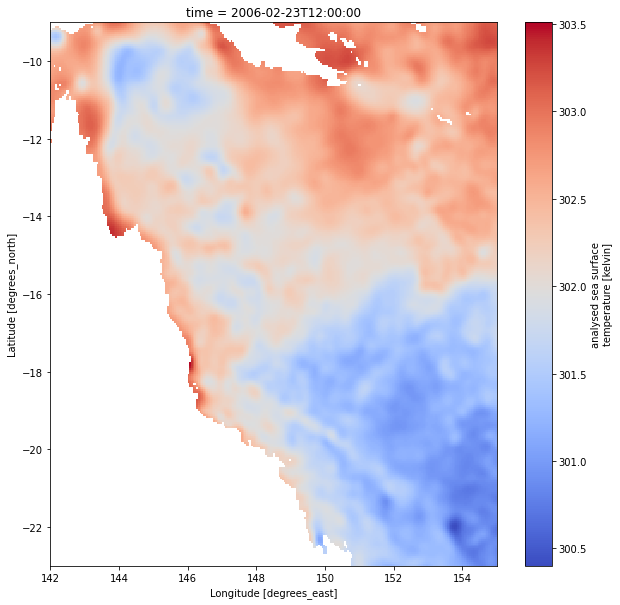

In [4]:
ssts_ts.plot(cmap="coolwarm",figsize=(10,10))

In [3]:
ssts_data = sst_ds["analysed_sst"].sel(time=slice("1990-01-31","1995-12-31")).sel(lat=slice(-23,-9),lon=slice(142,155))

In [7]:
means = ssts_data.groupby("time.dayofyear").mean("time").load()

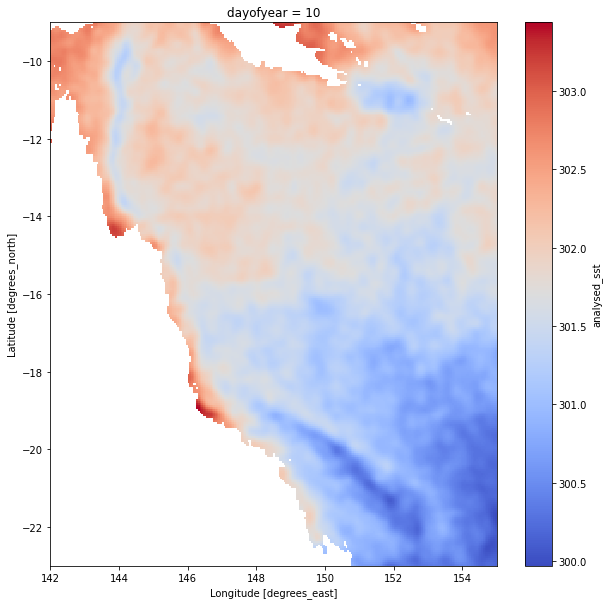

In [10]:

means.sel(dayofyear=10).plot(cmap="coolwarm",figsize=(10,10))

In [15]:
day5_rolling_means = means.rolling(dayofyear=10, center=True).mean().load()

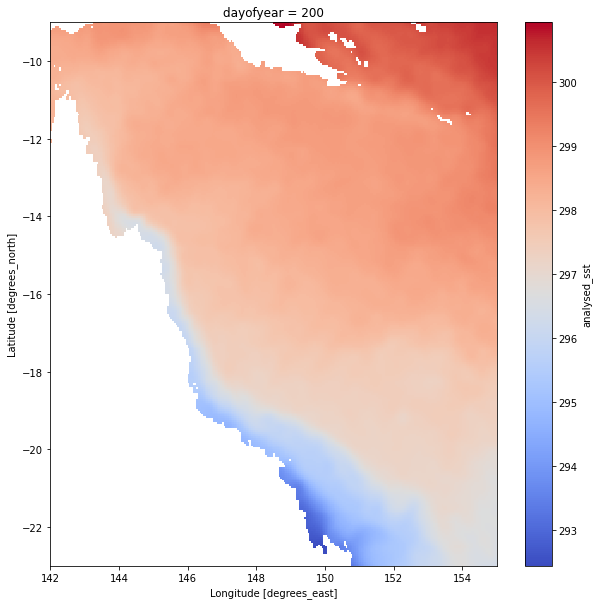

In [18]:
day5_rolling_means.sel(dayofyear=200).plot(cmap="coolwarm",figsize=(10,10))

In [4]:
p90s = xr.apply_ufunc(
    lambda x: np.nanpercentile(x, 90, axis=-1), ssts_data, input_core_dims=[["time"]], dask='allowed'
)

/Users/cv922550/venvs/sst_data/lib/python3.8/site-packages/dask/array/core.py:1503: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/Users/cv922550/venvs/sst_data/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


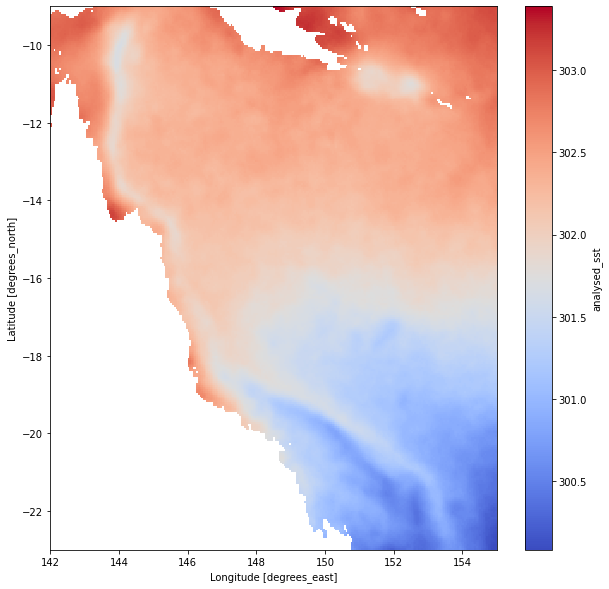

In [6]:
p90s.plot(cmap="coolwarm",figsize=(10,10))


In [4]:
p90s = ssts_data.quantile(0.9,dim="time")

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [8]:
ssts_data_rechunk = ssts_data.chunk({"lat": 10, "lon": 10, "time":-1})

In [10]:
p90s = ssts_data_rechunk.quantile(0.9,dim="time")

In [12]:
p90s = p90s.load()

/Users/cv922550/venvs/sst_data/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


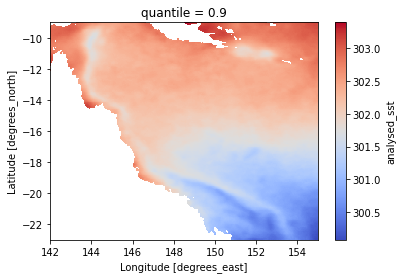

In [14]:
p90s.plot(cmap="coolwarm")

In [15]:
rolling = ssts_data_rechunk.rolling(time=5,center=True)

In [16]:
rdata = rolling.construct("window")

In [18]:
rdata = rdata.chunk({"time":-1})

In [19]:
rdata

,Array,Chunk
Bytes,2.93 GiB,4.12 MiB
Shape,"(2161, 280, 260, 5)","(2161, 10, 10, 5)"
Count,70710 Tasks,728 Chunks
Type,float32,numpy.ndarray


In [20]:
rdata2 = rdata.groupby("time.dayofyear")

In [21]:
rdata2

DataArrayGroupBy, grouped over 'dayofyear'
366 groups with labels 1, 2, 3, 4, 5, ..., 363, 364, 365, 366.

In [22]:
means = rdata2.mean(dim=["time","window"])

In [23]:
means

,Array,Chunk
Bytes,101.64 MiB,400 B
Shape,"(366, 280, 260)","(1, 10, 10)"
Count,1136502 Tasks,266448 Chunks
Type,float32,numpy.ndarray


In [24]:
p90s = rdata2.quantile(0.9,dim=["time","window"])

In [25]:
p90s

,Array,Chunk
Bytes,203.28 MiB,800 B
Shape,"(366, 280, 260)","(1, 10, 10)"
Count,2468742 Tasks,266448 Chunks
Type,float64,numpy.ndarray


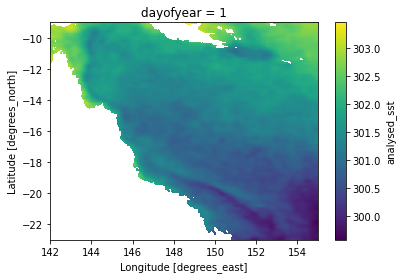

In [27]:
means.sel(dayofyear=1).plot()

/Users/cv922550/venvs/sst_data/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


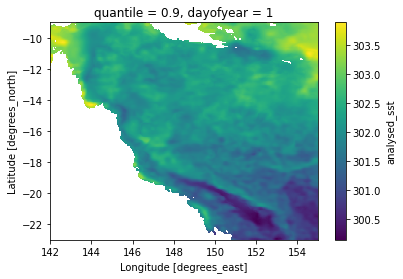

In [28]:
p90s.sel(dayofyear=1).plot()